# Generating adversarial example datasets with FGSM L1, L2, L-inf

In [1]:
%pip freeze

absl-py==2.1.0
accelerate==1.4.0
aiohappyeyeballs==2.4.4
aiohttp==3.11.11
aiosignal==1.3.2
altair==5.5.0
anyio==4.8.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==3.0.0
astunparse==1.6.3
async-lru==2.0.4
attrs==25.1.0
babel==2.17.0
beautifulsoup4==4.13.0
bleach==6.2.0
certifi==2025.1.31
cffi==1.17.1
charset-normalizer==3.4.1
cleverhans==4.0.0
cloudpickle==3.1.1
comm==0.2.2
contourpy==1.3.1
cycler==0.12.1
datasets==3.3.1
debugpy==1.8.12
decorator==5.1.1
defusedxml==0.7.1
dill==0.3.8
dm-tree==0.1.9
easydict==1.13
evaluate==0.4.3
executing==2.2.0
fastjsonschema==2.21.1
filelock==3.17.0
flatbuffers==25.1.24
fonttools==4.55.8
fqdn==1.5.1
frozenlist==1.5.0
fsspec==2024.9.0
gast==0.6.0
google-pasta==0.2.0
grpcio==1.70.0
h11==0.14.0
h5py==3.12.1
httpcore==1.0.7
httpx==0.28.1
huggingface-hub==0.28.1
idna==3.10
imbalanced-learn==0.13.0
imblearn==0.0
ipykernel==6.29.5
ipython==8.32.0
ipywidgets==8.1.5
isoduration==20.11.0
jedi==0.19.2
Jinja2==3.1.5
joblib==1.4.2
json5=

In [2]:
%pip install cleverhans

Note: you may need to restart the kernel to use updated packages.


## Prepare data

In [25]:
from pathlib import Path
import pandas as pd
import numpy as np

import gc
from datasets import Image, ClassLabel, Dataset as HuggingFaceDataset
from torch.utils.data import Dataset as TorchDataset

import torch

In [26]:
# filepath of saved csv version of dataset generated from HuggingFaceViT (New Dataset)
csv_save_dir = '/home/gscalubayan/diff-dataset/diff_df.csv'

def identifier_attrib(img_path):
    parts = Path(img_path).parts

    try:
        relative_path = parts[4:]
        if relative_path[0].lower() == "real":
            # e.g., Dataset/test/real/09048.png
            final_identifier = f'Dataset/{relative_path[2]}/real/{relative_path[-1]}'
        else:
            # e.g., Dataset/test/fake/FE/CoDiff/0C_interText_optDM_3_alpha=0.5.png
            final_identifier = f'Dataset/{relative_path[0]}/fake/{relative_path[1]}/{relative_path[2]}/{relative_path[-1]}'
        return final_identifier
    except Exception as e:
        print(f"Error with path: {img_path}\n{e}")
        return None
         
df = pd.read_csv(csv_save_dir)

df['identifier'] = df['image'].apply(identifier_attrib)

print(df.shape)

df.head()

(597937, 6)


,image,category,method,split,label,identifier
0,/home/gscalubayan/diff-dataset/real/DiFF_real/...,NaN,NaN,test,Real,Dataset/test/real/09048.png
1,/home/gscalubayan/diff-dataset/real/DiFF_real/...,NaN,NaN,test,Real,Dataset/test/real/00771.png
2,/home/gscalubayan/diff-dataset/real/DiFF_real/...,NaN,NaN,test,Real,Dataset/test/real/12576.png
3,/home/gscalubayan/diff-dataset/real/DiFF_real/...,NaN,NaN,test,Real,Dataset/test/real/12904.png
4,/home/gscalubayan/diff-dataset/real/DiFF_real/...,NaN,NaN,test,Real,Dataset/test/real/17228.png


In [32]:
# Create an image, label dataset from a Pandas DataFrame.
ClassLabels = ClassLabel(num_classes=2, names=['Real', 'Fake'])
# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = (
    HuggingFaceDataset.from_pandas(df)
    .cast_column('image', Image())
    .map(map_label2id, batched=True)
    .cast_column('label', ClassLabels)
)

AttributeError: type object 'Dataset' has no attribute 'Image'

In [4]:
dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'category': None,
 'method': None,
 'split': 'test',
 'label': 0,
 'identifier': 'Dataset/test/real/09048.png'}

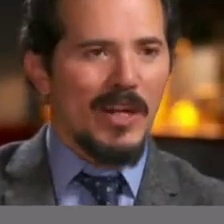

In [5]:
dataset[0]['image']

## Prepare model

In [6]:
from transformers import ViTImageProcessor, AutoModelForImageClassification

# Define the pre-trained ViT model string
model_str = "dima806/deepfake_vs_real_image_detection"
#"/home/gscalubayan/csg-aml1-sy2425/huggingface_deepfake_vs_real_image_detection/DiFF_deepfake_vs_real_image_detection/"
#"dima806/deepfake_vs_real_image_detection" # 'google/vit-base-patch16-224-in21k'

# Create a processor for ViT model input from the pre-trained model
processor = ViTImageProcessor.from_pretrained(model_str)
model = AutoModelForImageClassification.from_pretrained(model_str).to('cuda')

2025-04-16 10:38:45.658942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744771125.835293 2267151 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744771125.914115 2267151 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744771126.394867 2267151 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744771126.394901 2267151 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744771126.394903 2267151 computation_placer.cc:177] computation placer alr

In [7]:
# Get the size (height) of the ViT model's input images
size = processor.size["height"]

# Define a set of transformations for validation data
from torchvision.transforms import (  # Import image transformation functions
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    Resize,  # Resize images
    ToTensor,
)

convert_to_valid_tensor = Compose([
    Resize((size, size)),             # Resize images to the ViT model's input size
    ToTensor(),
    Normalize(mean=processor.image_mean, std=processor.image_std),
])

## Generating adversarial examples

In [8]:
from csv import DictWriter
from torch.utils.data import DataLoader

In [9]:
class deepfake_and_real(TorchDataset):
    def __getitem__(self, idx: int):
        tensor = convert_to_valid_tensor(dataset[idx]['image'].convert("RGB")).cuda()
        identifier = dataset[idx]['identifier']
        return tensor, identifier

    def __len__(self):
        return len(dataset)

In [10]:
# Turn images into tensors
tensor_data = deepfake_and_real()
data_loader = DataLoader(tensor_data, batch_size=4, shuffle=False) # batch size originally 64

### FGM

In [11]:
from torchvision.transforms.functional import to_pil_image
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, wait
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from tqdm import tqdm

In [12]:
img_save_path = '/home/gscalubayan/cs199/huggingfacevit/DiFF_adversarial/fgsm_l1/'
# this directory must follow the ff structure
# fgsm_l1/
# ├─ Test/
# │  ├─ Fake/
# │  ├─ Real/
# ├─ Train/
# │  ├─ Fake/
# │  ├─ Real/
# ├─ Validation/
# │  ├─ Fake/
# │  ├─ Real/

In [13]:
def generate_fgsm_l1_examples(model_fn, data_loader, epsilon):
    for tensor_batch, identifier_batch in tqdm(data_loader):
        adv_images = fast_gradient_method(model_fn, tensor_batch, epsilon, norm=1)
        
        ## move images to CPU and save
        #for img, identifier in zip(adv_images, identifier_batch):
        #    save_cuda_tensor(img, identifier)
            
        del tensor_batch #, adv_images
        torch.cuda.empty_cache()
        yield adv_images, model(adv_images), identifier_batch

def save_cuda_tensor(image: torch.cuda.FloatTensor, identifier: str):
    perturbed_img = to_pil_image(image.to('cpu')) # Move image to CPU before saving
    save_location = f'{img_save_path}{identifier}'
    save_dir = Path(save_location).parent  # Get the directory of the save location
    save_dir.mkdir(parents=True, exist_ok=True)  # Create any missing directories
    perturbed_img.save(save_location, 'JPEG')
    torch.cuda.empty_cache()

In [14]:
# WITH THREADING
# ONLY RUN ONCE to generate .csv of results
pending_jobs = []

with open(f'/home/gscalubayan/cs199/huggingfacevit/DiFF_fgsm_l1.csv', 'w', newline='') as csvfile:
    fieldnames = ['label', 'score', 'identifier']
    writer = DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model.eval()  # Ensure model is in evaluation mode
    softmax = torch.nn.Softmax()

    with ThreadPoolExecutor(max_workers=4) as ex: # max workers originally 16
        for images, outputs, identifiers in generate_fgsm_l1_examples(lambda image: model(image).logits, data_loader, 0.05):
            for img, identifier in zip(images, identifiers):
                pending_jobs.append(ex.submit(save_cuda_tensor, img, identifier))
            probabilities = softmax(outputs.logits)
            winners = torch.argmax(probabilities, dim=1)

            # Write on CSV file
            writer.writerows({ 
                'label': 'Fake' if winner == 1 else 'Real', 
                'score': probs[winner].item(), 
                'identifier': identifier 
            } for probs, winner, identifier in zip(probabilities, winners, identifiers))
            
            # Process jobs in smaller batches instead of waiting at the end
            if len(pending_jobs) > 100:  # Adjust threshold as needed
                wait(pending_jobs)  # Free memory earlier
                pending_jobs.clear()  # Remove completed jobs
                
            del outputs  # Explicitly delete outputs
            torch.cuda.empty_cache()
            
# Final cleanup of remaining jobs
wait(pending_jobs)
pending_jobs.clear()  # Extra precaution

/mnt/lustre/coe-lstr/home/gscalubayan/gscalubayan-env/lib/python3.12/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|█████████████████████████████████████████████████████████████████████████| 149485/149485 [7:04:35<00:00,  5.87it/s]


In [15]:
img_save_path = '/home/gscalubayan/cs199/huggingfacevit/DiFF_adversarial/fgsm_l2/'
# this directory must follow the ff structure
# fgsm_l2/
# ├─ Test/
# │  ├─ Fake/
# │  ├─ Real/
# ├─ Train/
# │  ├─ Fake/
# │  ├─ Real/
# ├─ Validation/
# │  ├─ Fake/
# │  ├─ Real/

In [16]:
def generate_fgsm_l2_examples(model_fn, data_loader, epsilon):
    for tensor_batch, identifier_batch in tqdm(data_loader):
        adv_images = fast_gradient_method(model_fn, tensor_batch, epsilon, norm=2)
        del tensor_batch
        torch.cuda.empty_cache()
        yield adv_images, model(adv_images), identifier_batch

def save_cuda_tensor(image: torch.cuda.FloatTensor, identifier: str):
    perturbed_img = to_pil_image(image.to('cpu')) # Move image to CPU before saving
    save_location = f'{img_save_path}{identifier}'
    save_dir = Path(save_location).parent  # Get the directory of the save location
    save_dir.mkdir(parents=True, exist_ok=True)  # Create any missing directories
    perturbed_img.save(save_location, 'JPEG')
    torch.cuda.empty_cache()

In [17]:
# WITH THREADING
# ONLY RUN ONCE to generate .csv of results
pending_jobs = []

with open(f'/home/gscalubayan/cs199/huggingfacevit/DiFF_fgsm_l2.csv', 'w', newline='') as csvfile:
    fieldnames = ['label', 'score', 'identifier']
    writer = DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model.eval()  # Ensure model is in evaluation mode
    softmax = torch.nn.Softmax()

    with ThreadPoolExecutor(max_workers=4) as ex: # max workers originally 16
        for images, outputs, identifiers in generate_fgsm_l2_examples(lambda image: model(image).logits, data_loader, 0.05):
            for img, identifier in zip(images, identifiers):
                pending_jobs.append(ex.submit(save_cuda_tensor, img, identifier))
            probabilities = softmax(outputs.logits)
            winners = torch.argmax(probabilities, dim=1)

            # Write on CSV file
            writer.writerows({ 
                'label': 'Fake' if winner == 1 else 'Real', 
                'score': probs[winner].item(), 
                'identifier': identifier 
            } for probs, winner, identifier in zip(probabilities, winners, identifiers))
            
            # Process jobs in smaller batches instead of waiting at the end
            if len(pending_jobs) > 100:  # Adjust threshold as needed
                wait(pending_jobs)  # Free memory earlier
                pending_jobs.clear()  # Remove completed jobs
                
            del outputs  # Explicitly delete outputs
            torch.cuda.empty_cache()
            
# Final cleanup of remaining jobs
wait(pending_jobs)
pending_jobs.clear()  # Extra precaution

/mnt/lustre/coe-lstr/home/gscalubayan/gscalubayan-env/lib/python3.12/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|█████████████████████████████████████████████████████████████████████████| 149485/149485 [6:26:44<00:00,  6.44it/s]


In [18]:
img_save_path = '/home/gscalubayan/cs199/huggingfacevit/DiFF_adversarial/fgsm_linf/'
# this directory must follow the ff structure
# fgsm_linf/
# ├─ Test/
# │  ├─ Fake/
# │  ├─ Real/
# ├─ Train/
# │  ├─ Fake/
# │  ├─ Real/
# ├─ Validation/
# │  ├─ Fake/
# │  ├─ Real/

In [19]:
def generate_fgsm_linf_examples(model_fn, data_loader, epsilon):
    for tensor_batch, identifier_batch in tqdm(data_loader):
        adv_images = fast_gradient_method(model_fn, tensor_batch, epsilon, norm=np.inf)
        del tensor_batch
        torch.cuda.empty_cache()
        yield adv_images, model(adv_images), identifier_batch

def save_cuda_tensor(image: torch.cuda.FloatTensor, identifier: str):
    perturbed_img = to_pil_image(image.to('cpu')) # Move image to CPU before saving
    save_location = f'{img_save_path}{identifier}'
    save_dir = Path(save_location).parent  # Get the directory of the save location
    save_dir.mkdir(parents=True, exist_ok=True)  # Create any missing directories
    perturbed_img.save(save_location, 'JPEG')
    torch.cuda.empty_cache()

In [20]:
# WITH THREADING
# ONLY RUN ONCE to generate .csv of results
pending_jobs = []

with open(f'/home/gscalubayan/cs199/huggingfacevit/DiFF_fgsm_linf.csv', 'w', newline='') as csvfile:
    fieldnames = ['label', 'score', 'identifier']
    writer = DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model.eval()  # Ensure model is in evaluation mode
    softmax = torch.nn.Softmax()

    with ThreadPoolExecutor(max_workers=4) as ex: # max workers originally 16
        for images, outputs, identifiers in generate_fgsm_linf_examples(lambda image: model(image).logits, data_loader, 0.05):
            for img, identifier in zip(images, identifiers):
                pending_jobs.append(ex.submit(save_cuda_tensor, img, identifier))
            probabilities = softmax(outputs.logits)
            winners = torch.argmax(probabilities, dim=1)

            # Write on CSV file
            writer.writerows({ 
                'label': 'Fake' if winner == 1 else 'Real', 
                'score': probs[winner].item(), 
                'identifier': identifier 
            } for probs, winner, identifier in zip(probabilities, winners, identifiers))
            
            # Process jobs in smaller batches instead of waiting at the end
            if len(pending_jobs) > 100:  # Adjust threshold as needed
                wait(pending_jobs)  # Free memory earlier
                pending_jobs.clear()  # Remove completed jobs
                
            del outputs  # Explicitly delete outputs
            torch.cuda.empty_cache()
            
# Final cleanup of remaining jobs
wait(pending_jobs)
pending_jobs.clear()  # Extra precaution

100%|█████████████████████████████████████████████████████████████████████████| 149485/149485 [6:50:20<00:00,  6.07it/s]


### Model Trained on DiFF Dataset 

In [30]:
# Define the pre-trained ViT model string
model_str = "/home/gscalubayan/csg-aml1-sy2425/huggingface_deepfake_vs_real_image_detection/DiFF_deepfake_vs_real_image_detection/"

# Create a processor for ViT model input from the pre-trained model
diff_processor = ViTImageProcessor.from_pretrained(model_str)
diff_model = AutoModelForImageClassification.from_pretrained(model_str).to('cuda')

diff_model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [31]:
# Get the size (height) of the ViT model's input images
size = diff_processor.size["height"]
transform = Compose([
    Resize((size, size)),
    ToTensor(),
    Normalize(mean=processor.image_mean, std=processor.image_std),
])

class AdversarialDataset(Dataset):
    def __init__(self, csv_path, img_root):
        self.df = pd.read_csv(csv_path)
        self.img_root = img_root
        self.transform = transform

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_root, row['identifier'])
        image = Image.open(img_path).convert('RGB')
        tensor = self.transform(image).cuda()
        return tensor, row['identifier'], row['label']

    def __len__(self):
        return len(self.df)

NameError: name 'Dataset' is not defined

In [ ]:
# Load dataset of saved adversarial examples
adv_l1_dataset = AdversarialDataset(
    '/home/gscalubayan/cs199/huggingfacevit/DiFF_fgsm_l1.csv',
    '/home/gscalubayan/cs199/huggingfacevit/DiFF_adversarial/fgsm_l1/'
)
data_loader = DataLoader(adv_l1_dataset, batch_size=4, shuffle=False)

In [ ]:
with open(f'/home/gscalubayan/cs199/huggingfacevit/DiFF_trained_fgsm_l1.csv', 'w', newline='') as csvfile:
    fieldnames = ['label', 'score', 'identifier']
    writer = DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    
    softmax = torch.nn.Softmax()

    with ThreadPoolExecutor(max_workers=4) as ex: # max workers originally 16
        for images, identifiers, labels in tqdm(data_loader):
            outputs = model(images)
            probabilities = softmax(outputs.logits)
            winners = torch.argmax(probabilities, dim=1)

            # Write on CSV file
            writer.writerows({ 
                'label': 'Fake' if winner == 1 else 'Real', 
                'score': probs[winner].item(), 
                'identifier': identifier 
            } for probs, winner, identifier in zip(probabilities, winners, identifiers))

            torch.cuda.empty_cache()

In [ ]:
# Load dataset of saved adversarial examples
adv_l2_dataset = AdversarialDataset(
    '/home/gscalubayan/cs199/huggingfacevit/DiFF_fgsm_l2.csv',
    '/home/gscalubayan/cs199/huggingfacevit/DiFF_adversarial/fgsm_l2/'
)
data_loader = DataLoader(adv_l2_dataset, batch_size=4, shuffle=False)

In [ ]:
with open(f'/home/gscalubayan/cs199/huggingfacevit/DiFF_trained_fgsm_l2.csv', 'w', newline='') as csvfile:
    fieldnames = ['label', 'score', 'identifier']
    writer = DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    
    softmax = torch.nn.Softmax()

    with ThreadPoolExecutor(max_workers=4) as ex: # max workers originally 16
        for images, identifiers, labels in tqdm(data_loader):
            outputs = model(images)
            probabilities = softmax(outputs.logits)
            winners = torch.argmax(probabilities, dim=1)

            # Write on CSV file
            writer.writerows({ 
                'label': 'Fake' if winner == 1 else 'Real', 
                'score': probs[winner].item(), 
                'identifier': identifier 
            } for probs, winner, identifier in zip(probabilities, winners, identifiers))

            torch.cuda.empty_cache()

In [ ]:
# Load dataset of saved adversarial examples
adv_linf_dataset = AdversarialDataset(
    '/home/gscalubayan/cs199/huggingfacevit/DiFF_fgsm_linf.csv',
    '/home/gscalubayan/cs199/huggingfacevit/DiFF_adversarial/fgsm_linf/'
)
data_loader = DataLoader(adv_linf_dataset, batch_size=4, shuffle=False)

In [ ]:
with open(f'/home/gscalubayan/cs199/huggingfacevit/DiFF_trained_fgsm_linf.csv', 'w', newline='') as csvfile:
    fieldnames = ['label', 'score', 'identifier']
    writer = DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    
    softmax = torch.nn.Softmax()

    with ThreadPoolExecutor(max_workers=4) as ex: # max workers originally 16
        for images, identifiers, labels in tqdm(data_loader):
            outputs = model(images)
            probabilities = softmax(outputs.logits)
            winners = torch.argmax(probabilities, dim=1)

            # Write on CSV file
            writer.writerows({ 
                'label': 'Fake' if winner == 1 else 'Real', 
                'score': probs[winner].item(), 
                'identifier': identifier 
            } for probs, winner, identifier in zip(probabilities, winners, identifiers))

            torch.cuda.empty_cache()